# Deep Q-Network

Deep Q-network (DQN) is one of the most popular deep RL algorithms and it started a series of research innovations that mark the history of RL. DQN claimed for the first time **superhuman level performance** on the [**Atari benchmark**](https://gymnasium.farama.org/environments/atari/) in which agents learned from raw pixel data from mere images ([V. Mnih, et al. **"Playing Atari with Deep Reinforcement Learning"**, NIPS 2013](https://arxiv.org/abs/1312.5602)).

<img src="./images/atari.png" width="500">

The two problems that consistently show up in the naive application of function approximation to RL (NFQ) are the **violations of the IID assumption** and the **non stationarity of targets**.

In supervised learning, we obtain a full dataset in advance. We pre-process it, shuffle it, and then split it into sets for training. One crucial step in this process is the **shuffling of the data set**. By doing so, we allow our optimization method to avoid developing overfitting biases, reduce the variance of the training process, speed up convergence, and overall learn a more general representation of the underlying data-generating process. In reinforcement learning data is **gathered online** (they come from a sequence, a time series, a trajectory) and the experience sample generated at time step t+1 correlates with the experience sample generated at time step t. Moreover, samples are not identically distributed, because they depend on the policy that generates the actions and the policy is changing through time (it improves).

Also, in supervised learning, the targets used for training are fixed values on our dataset (fixed throughout the training process). In reinforcement learning **targets move with every training step** of the network. At every training update step, we optimize the approximate value function and therefore change the shape of the function, possibly the entire value function. Changing the value function means that the target values change as well, which, in turn, means the targets used are no longer valid. Because the targets come from the network, even before we use them, we can assume targets are invalid or biased at a minimum.

<img src="./images/stationary-problem.png" width="600">

## Target networks

A way to make **target values more stationary** is to have **a separate network** that we can fix for multiple steps and reserve it for calculating more stationary targets. The network with this purpose in DQN is called the **target network**.

<img src="./images/target-network-1.png" width="508"> <img src="./images/target-network-2.png" width="500">

This mitigates the issue of "chasing your own tail" by artificially creating **several small supervised learning problems** presented sequentially to the agent. Targets are fixed for as many steps as we fix our target network. It substantially reduces the chance of divergence. The only difference with NFQ is **the age of the neural network weights**:

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{s,a} \left[ ( r + \gamma \underset{a}{\max} Q(s',a;\theta_i) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{s,a} \left[ ( r + \gamma \underset{a}{\max} Q(s',a;\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

Notice that in practice we don’t have two different networks. The target network is a **previous instance of the same neural network** that we freeze for a number of steps. The gradient update now has time to catch up to the target, which is much more stable when frozen. This adds stability to the updates. We use the same model architecture and "sometimes" update the weights of the target network to match the weights of the **online network**, which is the network we optimize on every step.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

         # creating the hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        # connecting the output layer 
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        
        # pass it through the input layer
        x = self.activation_fc(self.input_layer(x))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        
        # finally, for the output layer
        x = self.output_layer(x)
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to('cpu')
        actions = torch.from_numpy(actions).long().to('cpu')
        new_states = torch.from_numpy(new_states).float().to('cpu')
        rewards = torch.from_numpy(rewards).float().to('cpu')
        is_terminals = torch.from_numpy(is_terminals).float().to('cpu')
        return states, actions, new_states, rewards, is_terminals

By using the target network, we prevent the training process from spiraling around because we’re fixing the targets for multiple time steps, thus allowing the online network weights to move consistently toward the targets before an update changes the optimization problem, and a new one is set. But we also **slow down learning** because you’re no longer training on up-to-date values. It’s essential to **balance stability and speed** by tuning this hyperparameter.

Consider the optimize method of the new algorithm, notice that we use the target network to calculate the Q-values of the next state, but we use the online network to calculate the Q-values of the current state:

In [41]:
def optimize_model(self, experiences):

    # convert the experiences into separate arrays for each element
    states, actions, rewards, next_states, is_terminals = experiences

    # get the batch size
    batch_size = len(is_terminals)
        
    # get the values of the Q-function at next state (remember to detach
    # notice: we now query the "target" network to get the estimate of the next state 
    q_sp = self.target_model(next_states).detach()
        
    # get the max value of the next state
    max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
    
    # one important step, often overlooked, is to ensure 
    # terminal states are grounded to zero
    max_a_q_sp *= (1 - is_terminals)
        
    # calculate the target 
    target_q_sa = rewards + self.gamma * max_a_q_sp

    # finally, we get the current estimate of Q(s,a)    
    # notice: here we query the current "online" network
    q_sa = self.online_model(states).gather(1, actions)

    # create the errors
    td_errors = q_sa - target_q_sa
    
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mul(0.5).mean()

    self.optimizer.zero_grad()
    value_loss.backward()
    self.optimizer.step()

The following is the interaction step method on the new algorithm, notice that it uses the online network to explore the environment and the experience is collected in the replay buffer:

In [42]:
def interaction_step(self, state):
    
    # interact with environment using the exploration policy
    # notice how we use the online model for selecting actions
    action = self.train_strategy.select_action(self.online_model, state)

    # collect an experience tuple as usual    
    new_state, reward, is_terminal, is_truncated, info = self.env.step(action)

    # a failure is defined as follows
    is_failure = is_terminal and not is_truncated
    
    # collect the experience and store it in the replay buffer
    experience = (state, action, reward, new_state, float(is_failure))
    self.replay_memory.store(experience)

    # update episode stats
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
    
    return new_state, is_terminal

Finally, the following is how the target network gets updated with the online network:

In [43]:
def update_network(self):
    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
        target.data.copy_(online.data)

As in NFQ, need a method to evaluate the learned policy using a greedy strategy:

In [44]:
def evaluate(self, n_episodes=1):

    # create a list of returns of each episode
    rs = []

    # loop over the episodes
    for _ in range(n_episodes):

        # reset the environment before starting the episode
        s, d = self.env.reset()[0], False

        # initialize the return
        rs.append(0)

        # interact with the environment until the episode is done 
        while(True):

            # interact with environment using the exploitation policy
            a = self.eval_strategy.select_action(self.online_model, s)

            # collect an experience tuple as usual
            s, r, d, t, _ = self.env.step(a)

             # add the reward to the return of the episode
            rs[-1] += r

            if d or t:
                break
            
    return np.mean(rs), np.std(rs)

Another way to mitigate the non-stationarity issue, to some degree, is to use **larger networks**. With more powerful networks, subtle differences between states are more likely to be detected. Larger networks reduce the **aliasing** of state-action pairs (two states can look like the same to the neural network, but still possibly require different actions). However, a more powerful neural network takes longer to train: it needs more data (interaction time) and more compute (processing time).

## Experience Replay

In NFQ, we use a mini-batch of N samples, and train the network with this batch for K iterations, alternating between calculating new targets and optimizing the network. These N samples are temporally correlated, because most of them belong to the same trajectory. **Experience replay** consists of a data structure (**replay memory**, called D) that **holds M>>N experience samples for several steps**, allowing the **sampling of mini-batches from a broad set of past experiences**. In that way, the training process can use a more diverse mini-batch for performing updates, and the agent no longer has to fit the model to the same small mini-batch for multiple iterations. The replay buffer **gives the impression that data are IID**, so that the optimization method is stable. Samples appear independent and identically distributed because of the sampling from multiple trajectories and even policies at once.

<img src="./images/dqn.png" width="600">

The only difference with previous equation is that **we’re now obtaining the experiences we use for training by sampling uniformly at random the replay buffer D**, instead of using the online experiences as before:

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{s,a} \left[ ( r + \gamma \underset{a}{\max} Q(s',a;\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{(s,a) \sim U(D)} \left[ ( r + \gamma \underset{a}{\max} Q(s',a;\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

Unfortunately, the **implementation becomes a challenge when working with high-dimensional observations**, because poorly implemented replay buffers hit a **hardware memory limit** quickly. In image-based environments, for instance, where each state representation is a stack of the latest image frames, we probably don’t have enough memory to naively store the experience samples. 

In [45]:
import numpy as np

class ReplayMemory():
    def __init__(self, max_size=10000, batch_size=64):
        
        # initialize five arrays to hold states, actions, reward, next states, and done flags
        self.states      = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.next_states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.dones       = np.empty(shape=(max_size), dtype=np.ndarray)

        # variables to do storage and sampling
        self.max_size = max_size
        self.batch_size = batch_size
        self.idx = 0
        self.size = 0
    
    def store(self, sample):
        
        # store a new sample 
        state, action, reward, next_state, done = sample
        self.states[self.idx] = state
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = next_state
        self.dones[self.idx] = done

        # idx points to the next index to modify, so we increase it, 
        # also make sure it loops back after reaching the maximum size 
        # (the end of the buffer)
        self.idx += 1
        self.idx = self.idx % self.max_size

        # size also increases with every new sample stored, 
        # but it doesn’t loop back to 0; it stops growing instead
        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        
        # determining the batch size
        if batch_size == None:
            batch_size = self.batch_size

        # sample batch_size ids from 0 to size.    
        idxs = np.random.choice(self.size, batch_size, replace=False)
        
        # extract the experiences from the buffer using the sampled ids
        experiences = np.vstack(self.states[idxs]), \
                      np.vstack(self.actions[idxs]), \
                      np.vstack(self.rewards[idxs]), \
                      np.vstack(self.next_states[idxs]), \
                      np.vstack(self.dones[idxs])
                      
        return experiences

    # handy function to return the correct size of the memory
    def __len__(self):
        return self.size

## Exploration strategies

Exploration is a vital component of reinforcement learning. In the NFQ, we use an epsilon-greedy exploration strategy (acting randomly with epsilon probability), however this is not the only possible strategies (see notebook about "Exploration vs Exploitation"). In DQN, we use a **Exponentially decaying epsilon-greedy exploration strategy**. We start with a high epsilon value, and we exponentially decay it over time. This strategy allows the agent to explore the environment more at the beginning of the training process, and exploit it more at the end. It is simple and works well. But other, more advanced, strategies may be worth trying. Notice that even a small difference in hyper-parameters, can make a significant difference in performance. 

In [46]:
class EGreedyExpStrategy():
    
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        
        # epsilon is decaying in an exponential curve
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        
        self.exploratory_action_taken = False
        
        #with torch.no_grad():
        # pulling out the Q-values for state s
        q_values = model(state).detach()
        # make the values NumPy friendly 
        q_values = q_values.data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action


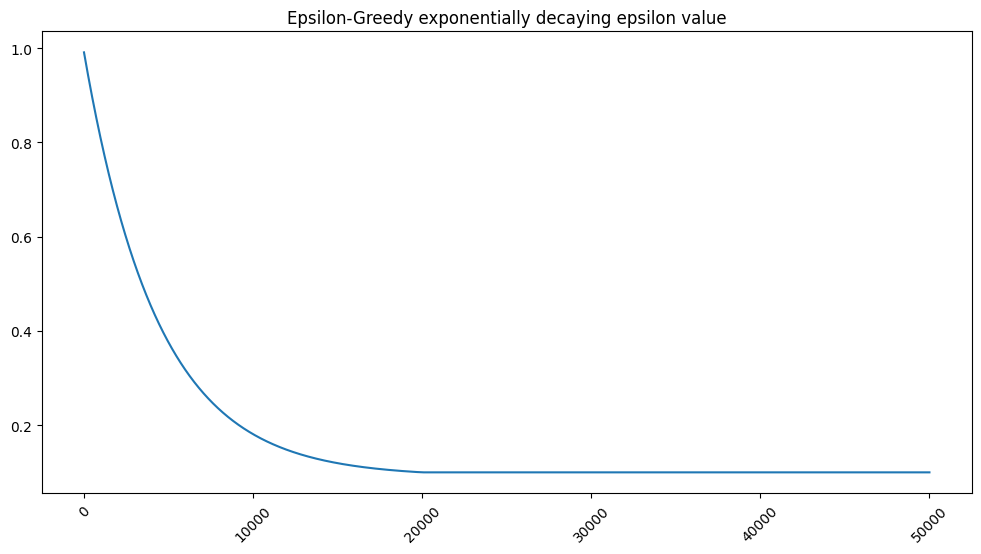

In [47]:
import matplotlib.pyplot as plt

s = EGreedyExpStrategy()

plt.figure(figsize=(12,6))
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy exponentially decaying epsilon value')
plt.xticks(rotation=45)

plt.show()

However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function. This means that we will always select the action that maximizes the action-value function, without any exploration. This is because we want to evaluate the agent’s performance, and not the exploration strategy.

In [48]:
class GreedyStrategy():
    
    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).detach()
            q_values = q_values.data.numpy().squeeze()
            return np.argmax(q_values)

## DQN 

We can now implement the full DQN algorithm, the main difference with NFQ are that we use an exponentially decaying epsilon-greedy strategy to improve policies, we use a replay buffer and a target network. So the algorithm has three main steps:

1. collect experience and insert it into the replay memory
2. randomly sample a mini-batch from the buffer, and calculate the off-policy TD targets for the whole batch
3. fit the action-value function Q(s,a; θ) using MSE and RMSprop

In [49]:
import random 
import torch
import torch.optim as optim

class DQN():
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory,
                 seed, n_warmup_batches, target_update_steps):
        
        # set the seed
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        # store the objects
        self.env = env
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

In [50]:
DQN.optimize_model = optimize_model
DQN.interaction_step = interaction_step
DQN.update_network = update_network
DQN.evaluate = evaluate

We need to write the new training loop, the difference with NFQ are that we need to sample a mini-batch from the replay memory,we never need to use the same mini-batch for multiple epochs and sometimes we have to synchronize the target network with the online network:

In [51]:
from itertools import count
import time

def train(self, gamma, max_minutes, max_episodes, goal_reward):
        
        # timing variables
        training_start = time.time()

        self.gamma = gamma
        
        # stats trackers 
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        # we synchronize the online and target models at the beginning of training
        self.update_network()
                    
        result = np.empty((max_episodes, 4))
        result[:] = np.nan

        training_time = 0
        
        # train until we either reach the max minutes, the max episodes or the goal mean reward
        for episode in range(1, max_episodes + 1):

            # get the start time of the episode
            episode_start = time.time()
            
            # reset the episode trackers
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # reset the environment before starting the episode
            state, is_terminal = self.env.reset()[0], False

            # interact with the environment until the episode is done
            for step in count():

                # interact with environment using the exploration policy
                # and collect the experience in the replay memory
                state, is_terminal = self.interaction_step(state)
                
                # if the replay memory has enough samples, we can create 
                # the mini-batch and optimize the model 
                min_samples = self.replay_memory.batch_size * self.n_warmup_batches
                if len(self.replay_memory) > min_samples:

                    # load the experiences as tensors for training
                    # from the replay memory
                    experiences = self.replay_memory.sample()
                    experiences = self.online_model.load(experiences)

                    # optimize the model
                    self.optimize_model(experiences)
                
                # synchronize the target model with the online model
                if np.sum(self.episode_timestep) % self.target_update_steps == 0:
                    self.update_network()
                
                if is_terminal:
                    break
            
            # timing stuff
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed

            # episode steps count
            total_step = int(np.sum(self.episode_timestep))

            # evaluate the learned policy after the episode
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
            
            # average stats over some recent episodes
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            # report results
            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
            # check max episodes, max minutes and goal achievement criteria
            total_elapsed = time.time() - training_start
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
            # informative print logging  
            debug_message = 'episode {:04}, steps {:06}, avg eval score {:05.1f} (+/- {:05.1f})'
            debug_message = debug_message.format(episode, total_step, mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            
            # conclude training if we have met any of the stopping conditions
            if training_is_over:
                print(debug_message)
                if reached_max_minutes: print(u'--> reached_max_minutes ')
                if reached_max_episodes: print(u'--> reached_max_episodes ')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward ')
                break
                
        # evaluate the final policy
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
        return result, final_eval_score, final_eval_std, training_time
    
DQN.train = train


## Test DQN performances

We can show the performance of DQN on the cart-pole environment in order to show that it is more powerful than NFQ. We can also show that the target network and the replay buffer are important for the stability of the algorithm.

In [52]:
import gymnasium
cartpole = gymnasium.make('CartPole-v1', render_mode="rgb_array")

In [53]:
gamma = 1.00

max_minutes = 20
max_episodes = 10000
goal_reward = 350

dqn_results = []
best_dqn_agent = None 
best_dqn_eval_score = float('-inf')

target_update_steps = 10
n_warmup_batches = 5

nS, nA = cartpole.observation_space.shape[0], cartpole.action_space.n

for seed in (12, 34, 56, 78, 90):
    
    print('Training started...')
    
    online_model = FCQ(nS, nA, hidden_dims=(512,128))
    target_model = FCQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(online_model.parameters(), lr=0.0005)
    replay_memory = ReplayMemory(max_size=50000, batch_size=64)
    train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
    eval_strategy = GreedyStrategy()
    
    agent = DQN(cartpole, online_model, target_model, optimizer, 
                train_strategy, eval_strategy, replay_memory, seed, 
                n_warmup_batches, target_update_steps)
    result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_reward)

    dqn_results.append(result)
    if score > best_dqn_eval_score:
        best_dqn_eval_score = score
        best_dqn_agent = agent

    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'.format(score, score_std, training_time))
    
dqn_results = np.array(dqn_results)

Training started...
episode 0188, steps 036924, avg eval score 351.1 (+/- 117.8)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 498.96±7.29 in 41.02s training time

Training started...
episode 0229, steps 078056, avg eval score 351.2 (+/- 136.6)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 495.25±47.26 in 99.54s training time

Training started...
episode 0212, steps 027074, avg eval score 351.0 (+/- 102.9)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 482.26±54.61 in 28.97s training time

Training started...
episode 1999, steps 257491, avg eval score 353.9 (+/- 147.0)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 481.88±47.28 in 370.12s training time

Training started...
episode 0212, steps 039098, avg eval score 350.9 (+/- 121.3)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 499.58±2.94 in 43.94s training time



In [54]:
dqn_max_steps, dqn_max_train_reward, dqn_max_eval_score, dqn_max_time = np.max(dqn_results, axis=0).T
dqn_min_steps, dqn_min_train_reward, dqn_min_eval_score, dqn_min_time = np.min(dqn_results, axis=0).T
dqn_mean_steps, dqn_mean_train_reward, dqn_mean_eval_score, dqn_mean_time = np.mean(dqn_results, axis=0).T
dqn_episodes = np.arange(len(dqn_mean_steps))

We can save the result to future comparison:

In [55]:
np.savez('dqn_results',
         dqn_max_steps = dqn_max_steps, dqn_max_train_reward = dqn_max_train_reward, dqn_max_eval_score = dqn_max_eval_score, dqn_max_time = dqn_max_time,
         dqn_min_steps = dqn_min_steps, dqn_min_train_reward = dqn_min_train_reward, dqn_min_eval_score = dqn_min_eval_score, dqn_min_time = dqn_min_time,  
         dqn_mean_steps = dqn_mean_steps, dqn_mean_train_reward = dqn_mean_train_reward, dqn_mean_eval_score = dqn_mean_eval_score, dqn_mean_time = dqn_mean_time)


We can load the result of NFQ in order to compare the performances of the two algorithms:

In [56]:
nfq_results = np.load('nfq_results.npz')
nfq_max_steps = nfq_results['nfq_max_steps']
nfq_max_train_reward = nfq_results['nfq_max_train_reward']
nfq_max_eval_score = nfq_results['nfq_max_eval_score']
nfq_max_time = nfq_results['nfq_max_time']
nfq_min_steps = nfq_results['nfq_min_steps']
nfq_min_train_reward = nfq_results['nfq_min_train_reward']
nfq_min_eval_score = nfq_results['nfq_min_eval_score']
nfq_min_time = nfq_results['nfq_min_time']
nfq_mean_steps = nfq_results['nfq_mean_steps']
nfq_mean_train_reward = nfq_results['nfq_mean_train_reward']
nfq_mean_eval_score = nfq_results['nfq_mean_eval_score']
nfq_mean_time = nfq_results['nfq_mean_time']
nfq_episodes = np.arange(len(nfq_mean_steps))

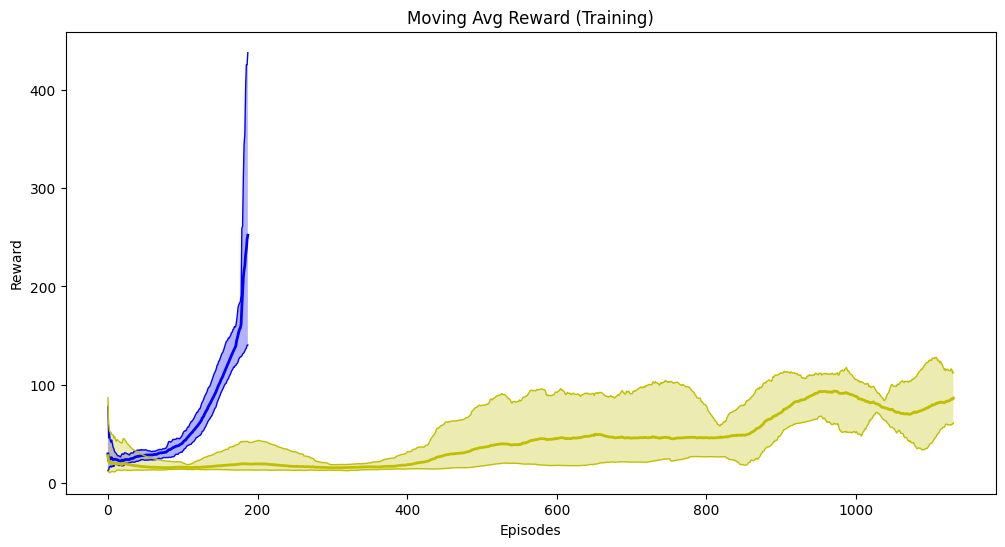

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(dqn_max_train_reward, 'b', linewidth=1)
plt.plot(dqn_min_train_reward, 'b', linewidth=1)
plt.plot(dqn_mean_train_reward, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_train_reward, dqn_max_train_reward, facecolor='b', alpha=0.3)

plt.plot(nfq_max_train_reward, 'y', linewidth=1)
plt.plot(nfq_min_train_reward, 'y', linewidth=1)
plt.plot(nfq_mean_train_reward, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_train_reward, nfq_max_train_reward, facecolor='y', alpha=0.3)

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

The most obvious conclusion we can draw is that DQN is more sample efficient than NFQ. But, if you pay attention to the curves, you notice how NFQ is also noisier than DQN.

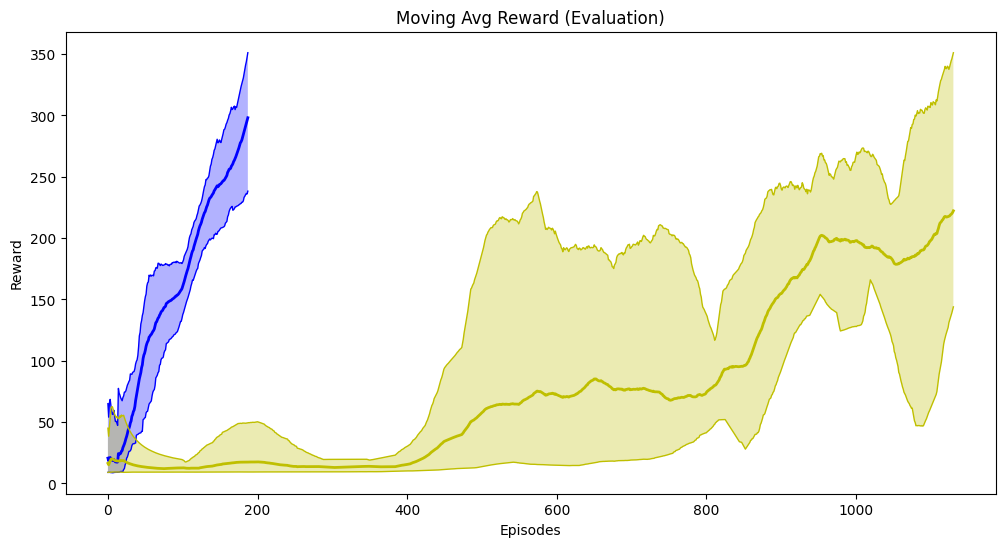

In [58]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_eval_score, 'b', linewidth=1)
plt.plot(dqn_min_eval_score, 'b', linewidth=1)
plt.plot(dqn_mean_eval_score, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_eval_score, dqn_max_eval_score, facecolor='b', alpha=0.3)

plt.plot(nfq_max_eval_score, 'y', linewidth=1)
plt.plot(nfq_min_eval_score, 'y', linewidth=1)
plt.plot(nfq_mean_eval_score, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_eval_score, nfq_max_eval_score, facecolor='y', alpha=0.3)

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

Notice that they both pass the cart-pole environment, but DQN takes approximately 200 episodes while NFQ takes almost 1,500 episodes. That’s a tenfold reduction in samples.

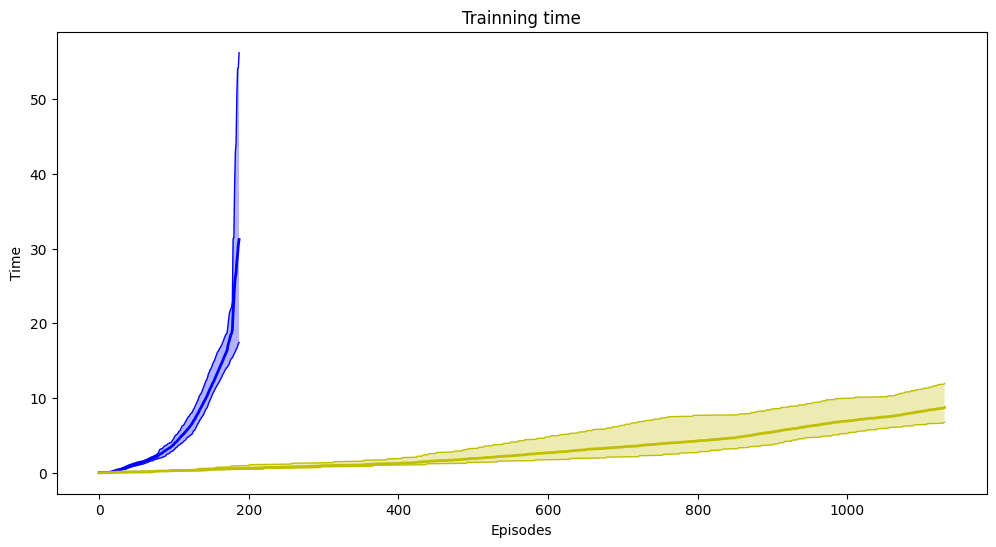

In [59]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_time, 'b', linewidth=1)
plt.plot(dqn_min_time, 'b', linewidth=1)
plt.plot(dqn_mean_time, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_time, dqn_max_time, facecolor='b', alpha=0.3)

plt.plot(nfq_max_time, 'y', linewidth=1)
plt.plot(nfq_min_time, 'y', linewidth=1)
plt.plot(nfq_mean_time, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_time, nfq_max_time, facecolor='y', alpha=0.3)

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')
plt.show()

However, DQN takes **more training time** than NFQ to pass the environment.

## Double DQN

In general, Q-learning **tends to overestimate action-value functions**, and the DQN agent is no different, we’re using the same off-policy TD target with the max operator. The problem is simple, we’re taking the max of estimated values and estimated values are often off-center, some higher than the true values, some lower, but the bottom line is that they’re off and we’re always taking the max of these values, so we have a preference for higher values, even if they aren’t correct. Our algorithms show a **positive bias**, and performance suffers. One way to better understand positive bias and how we can address it when using function approximation is by unwrapping the max operator in the target calculations: 

$\displaystyle
\nabla_{\theta_i} L_i(\theta_i)=E_{(s,a) \sim U(D)} \left[ ( r + \gamma \underset{a'}{\text{ max }} Q(s',a';\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

notice that the max of a Q-function is the same as the Q-function of the argmax action:

$\displaystyle
\underset{a'}{\text{ max }} Q(s',a';\theta^-) = Q(s',\underset{a'}{\arg \text{max }} Q(s',a';\theta^-);\theta^-) $

so we can modify the gradient expression as

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{(s,a) \sim U(D)} \left[ ( r + \gamma  Q(s',\underset{a'}{\arg \text{max }} Q(s',a';\theta^-);\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

There’s no real difference between the two equations, since both are using the same Q-values for the target. All we’re saying here is that taking the max is like asking the network "What’s the value of the highest-valued action in state s?" But, we are really asking two questions with a single question. First, we do an argmax, which is equivalent to asking, "Which action is the highest-valued action in state s?" and then, we use that action to get its value, equivalent to asking, "What’s the value of this action in state s?" One of the problems is that **we are asking both questions to the same Q-function, which shows bias in the same direction in both answers**. In other words, the function approximator will answer, "I think this one is the highest-valued action in state s, and this is its value". 

AN idea to reduce the chance of positive bias is to have **two instances of the action-value function** ([van Hasselt et al. **"Deep Reinforcement Learning with Double Q-learning"** (2015) AAAI Conference](https://arxiv.org/abs/1509.06461v3)), so we can ask one of the questions to one and the other question to the other. It’s somewhat like getting a second doctor’s opinion on health matters. In double learning, **one estimator selects the index of what it believes to be the highest-valued action, and the other estimator gives the value of this action**.

Implementing this procedure creates **unnecessary overhead** (we end up with four networks, two for training and two target networks) and it creates a **slowdown in the training process** (since we’d be training only one of these networks at a time). Fortunately, there’s a simple modification to the original double-learning procedure that adapts it to DQN and gives us substantial improvements without the extra overhead: **we can perform double learning with the other network we already have, which is the target network**. We use the online network (the network we’re training) for answering the first question (to find the index of the best action), then we use the target network to ask the second question (evaluate the selected action):

<img src="./images/ddqn.png" width="600">

So, the only difference in DDQN gradient expression is that now we use the online weights to select the action, but still use the frozen weights to get the estimate:

$\displaystyle
\nabla_{\theta_i} L_i(\theta_i)=E_{(s,a) \sim U(D)} \left[ ( r + \gamma Q(s',\underset{a'}{\arg \max} Q(s',a';\theta_i);\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

For NFQ and DQN we selected the **L2 loss** (mean square error (MSE), becouse it is a simple and ubiquitous loss function that works well. However, one of the issues using MSE is that it **penalizes large errors** more than small errors. This makes sense in supervised learning because our targets are the true value and are fixed throughout the training process. But in reinforcement learning, we don’t have true values and targets are constantly changing. So in this context being very wrong is something we expect and welcome. At the end of the day, if you think about it, we aren’t "training" agents, our agents learn on their own. 

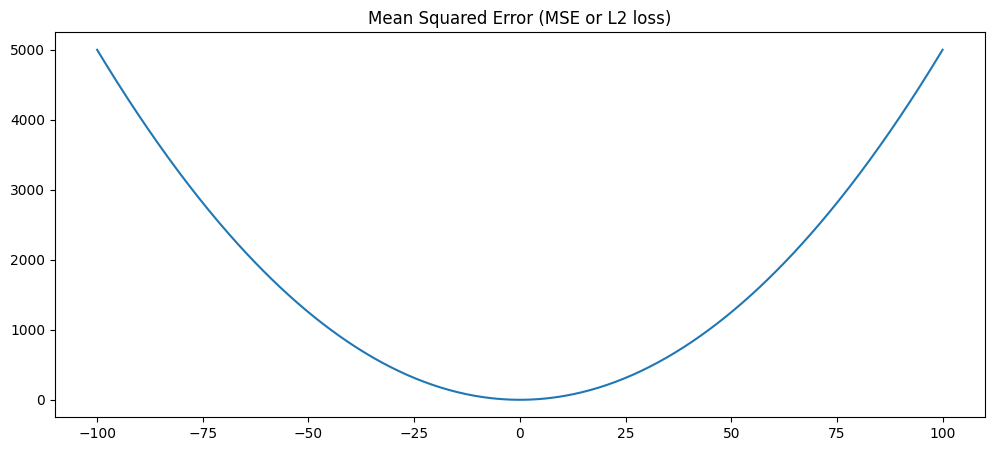

In [14]:
pred = np.linspace(-100,100,500)
truth = np.zeros(pred.shape)
error = truth - pred

mse = 0.5*error**2

plt.figure(figsize=(12,5))

plt.plot(pred, mse)
plt.title('Mean Squared Error (MSE or L2 loss)')
plt.show()


A loss function that we can use is the **L1 loss, mean absolute error (MAE)**, which is defined as the average absolute difference between the predicted and true values. MAE is a linear function (where MSE is quadratic) and we expect **it treats large errors the same way as small errors**. Being more resilient to outliers often implies errors have less effect, in terms of changes to our network, which means more stable learning. The flip side, one of the helpful things of MSE that MAE doesn’t have is the fact that its gradients decrease as the loss goes to zero. This feature is helpful for optimization methods because it makes it easier to reach the optima (lower gradients mean small changes to the network). 

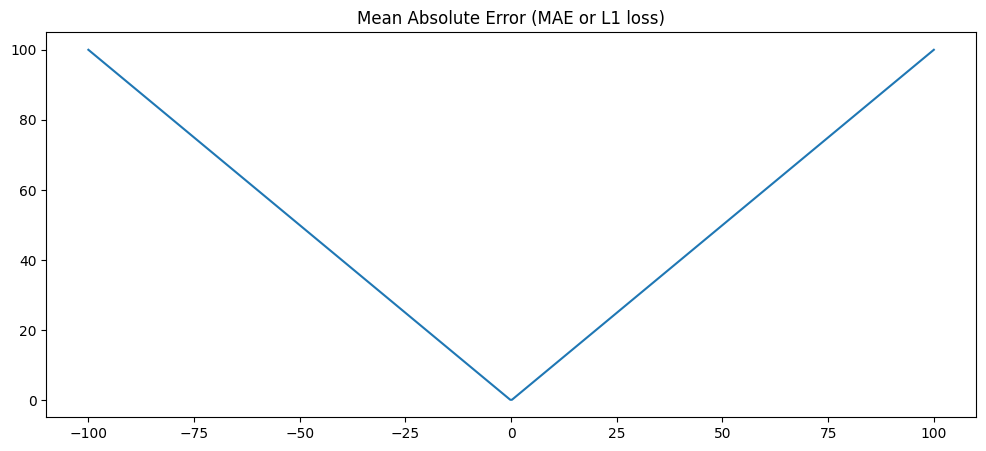

In [15]:
mae = np.abs(error)

plt.figure(figsize=(12,5))

plt.plot(pred, mae)
plt.title('Mean Absolute Error (MAE or L1 loss)')
plt.show()

Luckily, there’s a loss function that’s somewhat a mix of MSE and MAE, called the **Huber loss**, it is quadratic (curved) near-zero error, and it becomes linear (straight) for errors larger than a preset threshold. Having the best of both worlds makes the Huber loss **robust to outliers (like MAE) and differentiable at 0 (like MSE)**. The Huber loss uses a hyperparameter $\delta$, to set the threshold. There are at least two different ways of implementing the Huber loss function. We can compute it as defined, or we can compute the MSE loss and then set all gradients larger than a threshold to a fixed magnitude value. This is often referred to as **gradient clipping** and it is more flexible.

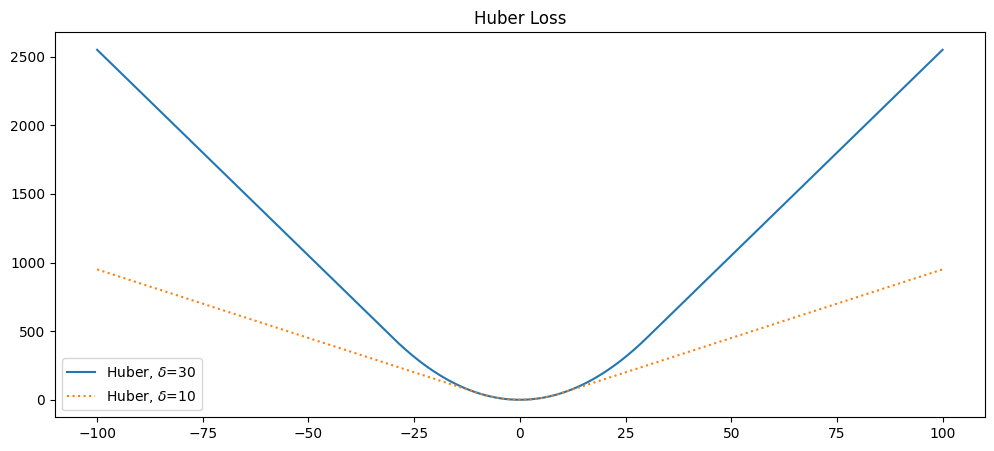

In [16]:
huber = lambda delta=1: mae - delta/2 if delta == 0 else \
              np.where(mae <= np.repeat(delta, len(mae)), mse, delta*(mae - delta/2))

plt.figure(figsize=(12,5))

plot1, = plt.plot(pred, huber(30))
plot2, = plt.plot(pred, huber(10), ':')
plt.title('Huber Loss')
plt.legend([plot1,plot2],["Huber, $\\delta$=30", "Huber, $\\delta$=10"])
plt.show()

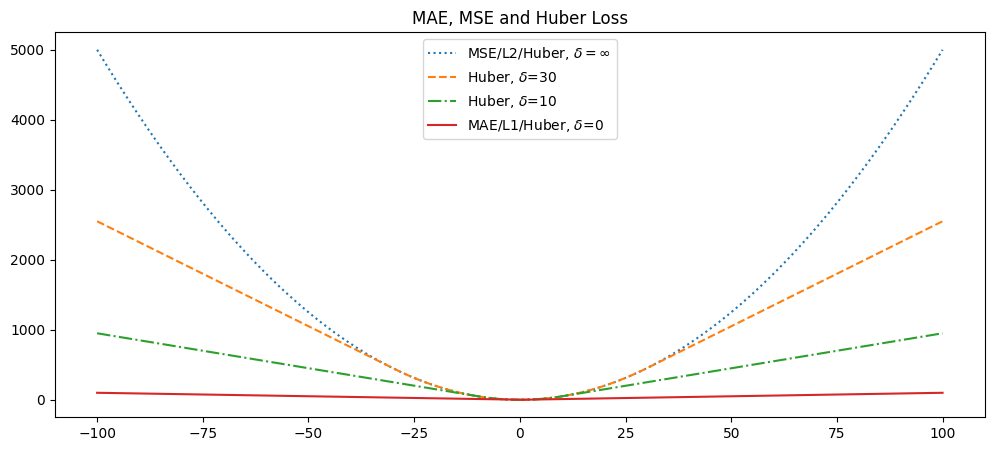

In [17]:
plt.figure(figsize=(12,5))

plot1, = plt.plot(pred, huber(float('inf')), ':')
plot2, = plt.plot(pred, huber(30), '--')
plot3, = plt.plot(pred, huber(10), '-.')
plot4, = plt.plot(pred, huber(0))

plt.title('MAE, MSE and Huber Loss')
plt.legend([plot1,plot2,plot3,plot4],["MSE/L2/Huber, $\\delta=\\infty$", "Huber, $\\delta$=30", "Huber, $\\delta$=10", "MAE/L1/Huber, $\\delta$=0"])
plt.show()

We can write the optimize_model function in order to use the Huber loss:

In [31]:
def optimize_model_ddqn(self, experiences):

    # convert the experiences into separate arrays for each element
    states, actions, rewards, next_states, is_terminals = experiences

    # get the batch size
    batch_size = len(is_terminals)
        
    # get the values of the Q-function at next state (remember to detach
    # notice: we now query the "target" network to get the estimate of the next state 
    q_sp = self.target_model(next_states).detach()
        
    # get the max value of the next state
    max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
    
    # one important step, often overlooked, is to ensure 
    # terminal states are grounded to zero
    max_a_q_sp *= (1 - is_terminals)
        
    # calculate the target 
    target_q_sa = rewards + self.gamma * max_a_q_sp

    # finally, we get the current estimate of Q(s,a)    
    # notice: here we query the current "online" network
    q_sa = self.online_model(states).gather(1, actions)

    # create the errors
    td_errors = q_sa - target_q_sa
    
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mul(0.5).mean()

    self.optimizer.zero_grad()
    value_loss.backward()

    # clip the gradients to the max_gradient_norm.
    torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), self.max_gradient_norm)
    
    self.optimizer.step()

We can put all things together and write the DDQN network, which is almost identical to DQN:

In [32]:
class DDQN():
    
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory, max_gradient_norm,
                 seed, n_warmup_batches, target_update_steps):
        
        # set the seed
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        # store the objects
        self.env = env
        self.replay_memory = replay_memory
        self.max_gradient_norm = max_gradient_norm
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

In [33]:
DDQN.optimize_model = optimize_model_ddqn
DDQN.interaction_step = interaction_step
DDQN.update_network = update_network
DDQN.evaluate = evaluate
DDQN.train = train

## DDQN vs DQN

DDQN and DQN have similar performance in the cart-pole environment. However, this is a
simple environment with a smooth reward function. In real problems, DDQN should always give better performance.

In [34]:
gamma = 1.00

max_minutes = 20
max_episodes = 10000
goal_reward = 350

ddqn_results = []
best_ddqn_agent = None 
best_ddqn_eval_score = float('-inf')

target_update_steps = 10
n_warmup_batches = 5

max_gradient_norm = float('inf')

nS, nA = cartpole.observation_space.shape[0], cartpole.action_space.n

for seed in (12, 34, 56, 78, 90):
    
    print('Training started...')
    
    online_model = FCQ(nS, nA, hidden_dims=(512,128))
    target_model = FCQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(online_model.parameters(), lr=0.0007)
    replay_memory = ReplayMemory(max_size=50000, batch_size=64)
    train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
    eval_strategy = GreedyStrategy()
    
    agent = DDQN(cartpole, online_model, target_model, optimizer, 
                train_strategy, eval_strategy, replay_memory, max_gradient_norm, 
                seed, n_warmup_batches, target_update_steps)
    result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_reward)

    ddqn_results.append(result)
    if score > best_ddqn_eval_score:
        best_ddqn_eval_score = score
        best_ddqn_agent = agent

    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'.format(score, score_std, training_time))
        
ddqn_results = np.array(ddqn_results)

Training started...
episode 0204, steps 063913, avg eval score 352.7 (+/- 141.6)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 87.43s training time

Training started...
episode 0172, steps 020107, avg eval score 350.7 (+/- 104.4)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 418.40±90.74 in 23.26s training time

Training started...
episode 0211, steps 049254, avg eval score 351.7 (+/- 108.0)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 65.23s training time

Training started...
episode 0202, steps 029040, avg eval score 352.4 (+/- 128.2)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 35.16s training time

Training started...
episode 0188, steps 024181, avg eval score 350.9 (+/- 104.5)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 413.79±85.86 in 28.56s training time



In [35]:
ddqn_max_steps, ddqn_max_train_reward, ddqn_max_eval_score, ddqn_max_time = np.max(ddqn_results, axis=0).T
ddqn_min_steps, ddqn_min_train_reward, ddqn_min_eval_score, ddqn_min_time = np.min(ddqn_results, axis=0).T
ddqn_mean_steps, ddqn_mean_train_reward, ddqn_mean_eval_score, ddqn_mean_time = np.mean(ddqn_results, axis=0).T
ddqn_episodes = np.arange(len(ddqn_mean_steps))

We can save the result to future comparison:

In [36]:
np.savez('ddqn_results',
         ddqn_max_steps = ddqn_max_steps, ddqn_max_train_reward = ddqn_max_train_reward, ddqn_max_eval_score = ddqn_max_eval_score, ddqn_max_time = ddqn_max_time,
         ddqn_min_steps = ddqn_min_steps, ddqn_min_train_reward = ddqn_min_train_reward, ddqn_min_eval_score = ddqn_min_eval_score, ddqn_min_time = ddqn_min_time,  
         ddqn_mean_steps = ddqn_mean_steps, ddqn_mean_train_reward = ddqn_mean_train_reward, ddqn_mean_eval_score = ddqn_mean_eval_score, ddqn_mean_time = ddqn_mean_time)


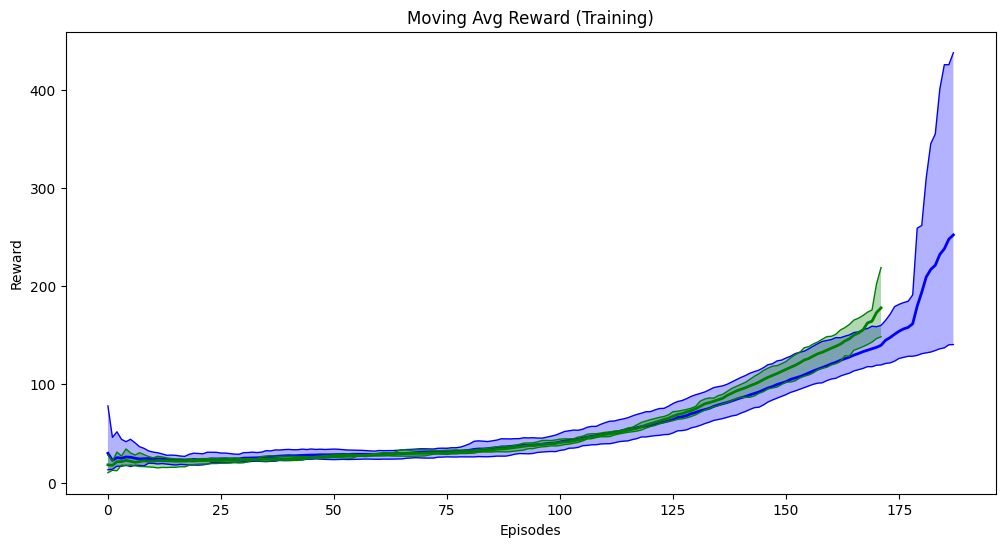

In [60]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_train_reward, 'b', linewidth=1)
plt.plot(dqn_min_train_reward, 'b', linewidth=1)
plt.plot(dqn_mean_train_reward, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_train_reward, dqn_max_train_reward, facecolor='b', alpha=0.3)

plt.plot(ddqn_max_train_reward, 'g', linewidth=1)
plt.plot(ddqn_min_train_reward, 'g', linewidth=1)
plt.plot(ddqn_mean_train_reward, 'g', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_train_reward, ddqn_max_train_reward, facecolor='g', alpha=0.3)

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

Notice the top and bottom bounds (representing the maximum and minimum values obtained by any of the five seeds during that episode). DDQN shows tighter bounds demonstrating **more stability** on performance.


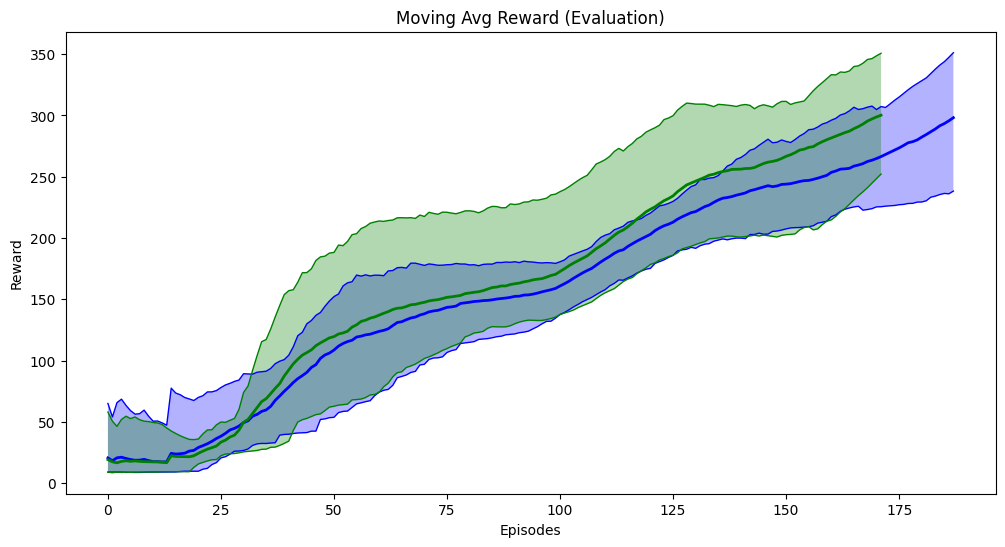

In [62]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_eval_score, 'b', linewidth=1)
plt.plot(dqn_min_eval_score, 'b', linewidth=1)
plt.plot(dqn_mean_eval_score, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_eval_score, dqn_max_eval_score, facecolor='b', alpha=0.3)

plt.plot(ddqn_max_eval_score, 'g', linewidth=1)
plt.plot(ddqn_min_eval_score, 'g', linewidth=1)
plt.plot(ddqn_mean_eval_score, 'g', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_eval_score, ddqn_max_eval_score, facecolor='g', alpha=0.3)

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

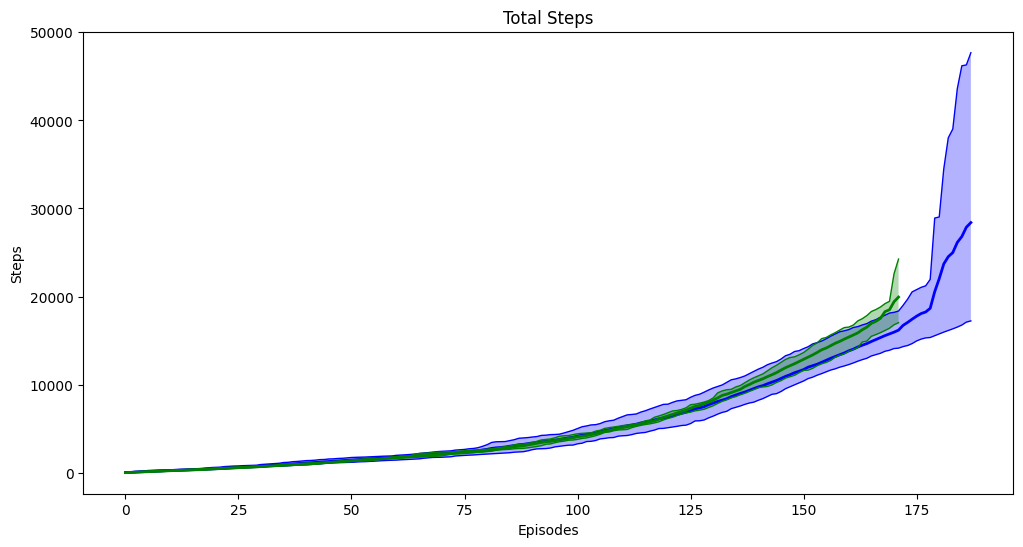

In [63]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_steps, 'b', linewidth=1)
plt.plot(dqn_min_steps, 'b', linewidth=1)
plt.plot(dqn_mean_steps, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_steps, dqn_max_steps, facecolor='b', alpha=0.3)

plt.plot(ddqn_max_steps, 'g', linewidth=1)
plt.plot(ddqn_min_steps, 'g', linewidth=1)
plt.plot(ddqn_mean_steps, 'g', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_steps, ddqn_max_steps, facecolor='g', alpha=0.3)

plt.title('Total Steps')
plt.ylabel('Steps')
plt.xlabel('Episodes')
plt.show()

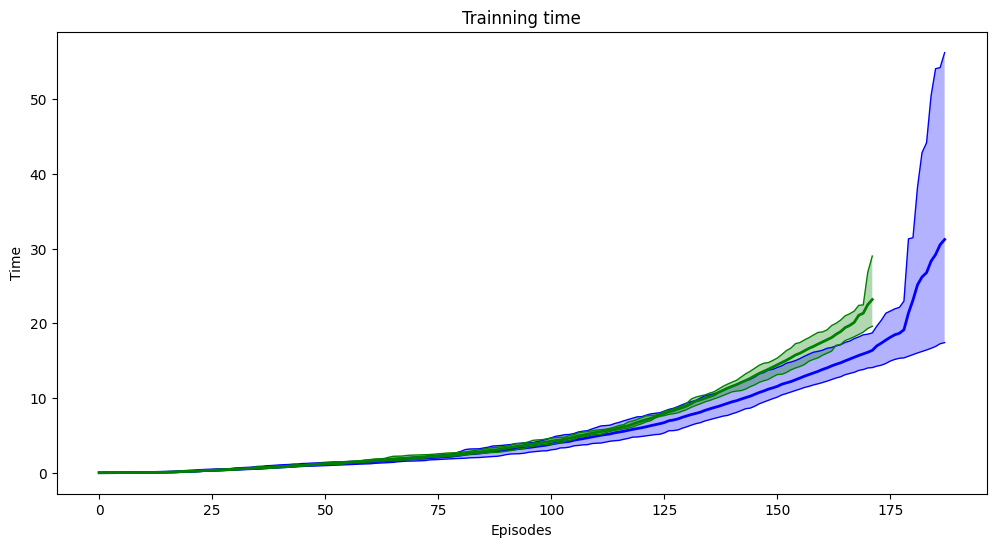

In [64]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_time, 'b', linewidth=1)
plt.plot(dqn_min_time, 'b', linewidth=1)
plt.plot(dqn_mean_time, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_time, dqn_max_time, facecolor='b', alpha=0.3)

plt.plot(ddqn_max_time, 'g', linewidth=1)
plt.plot(ddqn_min_time, 'g', linewidth=1)
plt.plot(ddqn_mean_time, 'g', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_time, ddqn_max_time, facecolor='g', alpha=0.3)

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')
plt.show()

In terms of time, DDQN take a bit longer than DQN to successfully pass the environment.